# Fee Mechanism Scenarios

In [1]:
import plotly.io as pio
pio.renderers.default = "png"

import sys
sys.path.append('../')

from aztec_gddt.analysis.execute import execute_sim, complexity_desc
from aztec_gddt.analysis.visualizations import plot_agg_kpis, plot_inspect_vars
from aztec_gddt.analysis.metrics import *
from aztec_gddt.scenario_experiments import *

import gcsfs
fs = gcsfs.GCSFileSystem()

## Summary

The **Fee Mechanism** scenario group is a series of simulations designed to help inform the specification of protocol parameters that are expected to impact the fee mechanism, either directly as part of its definition or indirectly by influencing the demand for and/or supply of Aztec transactions services. 

Each scenario within the group focuses on upon a different aspect of the environment the fee mechanism operates within. For example, the volatility scenario assesses the amplification or attenuation of secondary market price volatility on the base fee, while the shock analysis scenario investigates the dynamics of the base fee when it is perturbed by gas price shocks (i.e. abrupt changes with or without a volatility 'tail'). 

The underlying mechanisms and many of the protocol parameters are the same across the scenarios within the group--but the different environmental aspects determine which protocol parameters are under particular scrutiny and hence which are "swept" across different potential values. Because protocol parameters are under control of the system designer, these parameters of study are denoted "control parameters". By contrast, parameters that determine the type of environment, such as the volatility or shock magnitude of a secondary price process, are outside of the direct control of the designer and are denoted "environmental parameters". Environmental parameters usually specify 1) the _trend_ of one or more external processes, such as secondary market prices, and 2) the _distribution_ from which an environmental effect is randomly drawn.

Different combinations of control and environmental parameter values generate different simulation outcomes. The assessment and analysis of these different outcomes are facilitated by two simulation methodologies:
1. Key Performance Indicators (KPIs): also called 'metrics', these variables are measurements that help analyze simulation outcomes. KPIs are assessed according to desired system properties (_success criteria_), usually by comparing a KPI (or a function of several KPIs, as described in #2 below) to a minimum or maximum _threshold value_ within one or more _threshold inequalities_. Threshold inequalities quantify the success criteria specified by stakeholders and provide a means of determining which parameter combinations support simulation outcomes that fulfill these criteria.
2. Monte Carlo simulations: as described above, environmental parameters specify trends and random realizations from distributions that are parameterized by one or more environmental parameters. To capture the overall effect of the environment, several different realizations are usually drawn and a full simulation run performed for each. The resulting outcome is a _Monte Carlo_ (or MC) _run_, and robust results are obtained by examining the moments, quantiles etc. of the KPIs across MC runs.

## Scenarios

1. Volatility: The volatility scenario tests the effect of secondary market volatility on the volatility of the base fee and on the profitability of a sequencer or prover.
2. L2 Cost Censorship: The L2 Cost Censorship scenario assesses the relative inclusion of L2 transactions, by simulating user-provided maximum fee per _mana_ values and comparing them to base fee realizations, with the intuition that a transactions will only be included if its maximum fee will at least cover the base fee cost. 
3. Congestion Shock Analysis: The shock analysis scenario tests the effects of both L2 network congestion and L1 network congestion (represented through L1 gas prices changes) on the base fee dynamics. 
4. Oracle Sensitivity: The oracle sensitivity scenario tests the sensitivity of the fee mechanism to small errors that may propagate via an oracle channel, where actual values can diverge from those used for computation due to lags (caused by e.g. a slow update frequency relative to block time, and a slower magnitude of change relative to an actual value change).


## 1. Volatility

In [2]:
# exp_spec = experiment_feemech_volatility

# # Override default configuration
# exp_spec.N_timesteps = 1_000
# exp_spec.N_samples = 1
# exp_spec.N_config_sample = 40

# CONTROL_PARAMS = list(exp_spec.params_swept_control.keys())

# sim_df, exec_time = execute_sim(exp_spec.prepare())
# agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)

path = 'gs://aztec-gddt-v2-sim/FM-SG1/2025-01-31T03:53:07Z/'

with fs.open(path + 'spec.json', 'r') as fid:
    exp_spec = ExperimentParamSpec.from_json(fid.read()) # type: ginore

sim_df = pd.read_pickle(path + 'timestep_tensor-0.pkl.gz')
agg_df = pd.read_pickle(path + 'trajectory_tensor.pkl.gz')
c_agg_df = compute_agg_df(exp_spec.relevant_per_trajectory_group_metrics, agg_df)

### Objective 
The current specification of the fee mechanism requires a conversion from _gwei_ to Fee Asset. This implies that secondary market volatility of that asset pair has effects on each realization of the base fee and as such presents an uncertain outcome on quality of service for both end users and service provisioning by sequencers and provers. 
This scenario tests the propagation of secondary market volatility of the Fee Asset price to 1) the volatility of the base fee, denominated in terms of Fee Asset per _mana_, 2) the profitability of the sequencer, and 3) the profitability of the prover.

### Experimental Setup

#### Testing Variables: 
:dart: we should check tthe below variables 

##### Environmental:
Different exchange rate (between the Fee Asset and _gwei_) behaviors are realized over the course of a given environmental scenario. Exchange rate scenarios are modeled as particular shocks, where the exchange rate either:

1. Strictly increases at a parameterized maximum change throughout the simulation, or 
2. Strictly decreases at a parameterized maximum change throughout the simulation, or
3. Is realized from random draws from a parameterized distribution, or
4. Stagnates without much change throughout the simulation.

These scenario 'subgroups' act as proxies for different environmental realizations of secondary market effects on the base fee. 

##### Protocol: 
Different protocol parameters are investigated for their impact upon the base fee over the different environmental scenario subgroups described above. As the base fee is computed from various parametrizable components which do not have strong _ex ante_ values, this scenario tests a first group of parameter choices. 

This group consists of:

1. `OVERHEAD_MANA_PER_TX` - Each transaction incurs overhead mana costs of this size, irrespective of any conducted operations. 
2. `MAXIMUM_MANA_PER_BLOCK` - Each block is limited in *size* by this value, affecting profitability of sequencers, throughput of the network, and the computation of base fees directly. 
3. `TARGET_MANA_PER_BLOCK` - This value is needed to compute the congestion component of the base fee. 
4. `MAXIMUM_FEE_JUICE_PER_GWEI_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real secondary market price updates. In other words, the real secondary market price can fluctuate freely (such as in a flashcrash), while the oracle value used in practice by users is limited in change. Through this the base fee might lag behind in its conversion component when compared to a "real" secondary market price value used in computation. 
5. `MAXIMUM_PROVING_COST_GWEI_PER_MANA_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real proving cost updates. In other words, the proving cost experienced by provers might differ from the oracle value used in practice by users. Through this the base fee might lag behind in its proving cost component when compared to a "real" secondary market price value used in computation. 

#### Simulation input/output per Monte Carlo run:

##### Input:
For each parameter constellation of interest, we draw a simulated time series of secondary market Fee Asset price used to pay the transaction fee. For random realizations, the distribution is parameterized by the first two moments (mean, variance).

##### Output:
- $\mathcal{M}$ Monte Carlo runs indexed by $m$.
- Time series of the base fee denominated in Fee Asset per _mana_
- Number of empty slots per epoch, for each $m$th Monte Carlo run.

#### Sweep Parameters:
Refer to the [spreadsheet](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=955157985#gid=955157985&range=A1) for detailed parameter configurations related to staking and slashing mechanisms.

:dart: Fill in :dart:

##### Control:

In [3]:
exp_spec.print_control_params()

RELATIVE_TARGET_MANA_PER_BLOCK: [0.5, 0.9]
MAXIMUM_MANA_PER_BLOCK: [20000000, 40000000]
MINIMUM_MULTIPLIER_CONGESTION: [1000000, 4000000, 10000000]
RELATIVE_UPDATE_FRACTION_CONGESTION: [0.1, 1.0, 10.0]
OVERHEAD_MANA_PER_TX: [1000, 10000, 50000]
MAXIMUM_UPDATE_PERCENTAGE_C: [0.01, 0.03]


##### Environmental:

In [4]:
exp_spec.print_env_params()

JUICE_PER_GWEI_MEAN: [1.1e-15, 1e-14]
JUICE_PER_GWEI_COV: [0.03, 0.3]


#### Simulation Behavior:
1. A sequencer will not post a block to L1 if the revenue from the block is less than the cost of posting the block.
2. A prover will not post a proof to L1 if the revenue from proving is less than the cost of posting the block.

#### Threshold Inequalities:

#### Metrics:
1. **Average relative volatility:** $\bar{(\frac{\sigma_B}{\sigma_A})}$, where the average is taken over the $\mathcal{M}$ MC runs of the values $\sigma_B^m$/$\sigma_A^m$, $m = 1 , … ,\mathcal{M}$, and $\sigma_A^m$ and $\sigma_B^m$ are the volatility measures for the ASSET time series and BASE FEE time series for MC run $m$, respectively.

     _Interpretation_: A value of the metric greater than 1 indicates that ASSET price volatility is amplified, while a volatility less than 1 indicates that ASSET price volatility is attenuated.

2. **Average number of empty block slots** over the $\mathcal{M}$ MC runs.

     _Interpretation_: A large number of empty slots implies that posting blocks to L1 is unprofitable for a sequencer.

3. **Average number of unproven epochs** over the $\mathcal{M}$ MC runs.

     _Interpretation_: A large number of unproven epochs implies that posting proofs to L1 is unprofitable for a prover.



### Computational Complexity

In [5]:
print(complexity_desc(exp_spec))


    #### Computational Complexity:
    1. Total number of parameter combinations: 864
    2. Total number of Monte Carlo runs per parameter combination: 5
    3. Total number of trajectories: 4,320
    4. Total number of timesteps per trajectory: 3,000
    5. Total number of state measurements: 12,960,000
    


### Simulation Results 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart: 

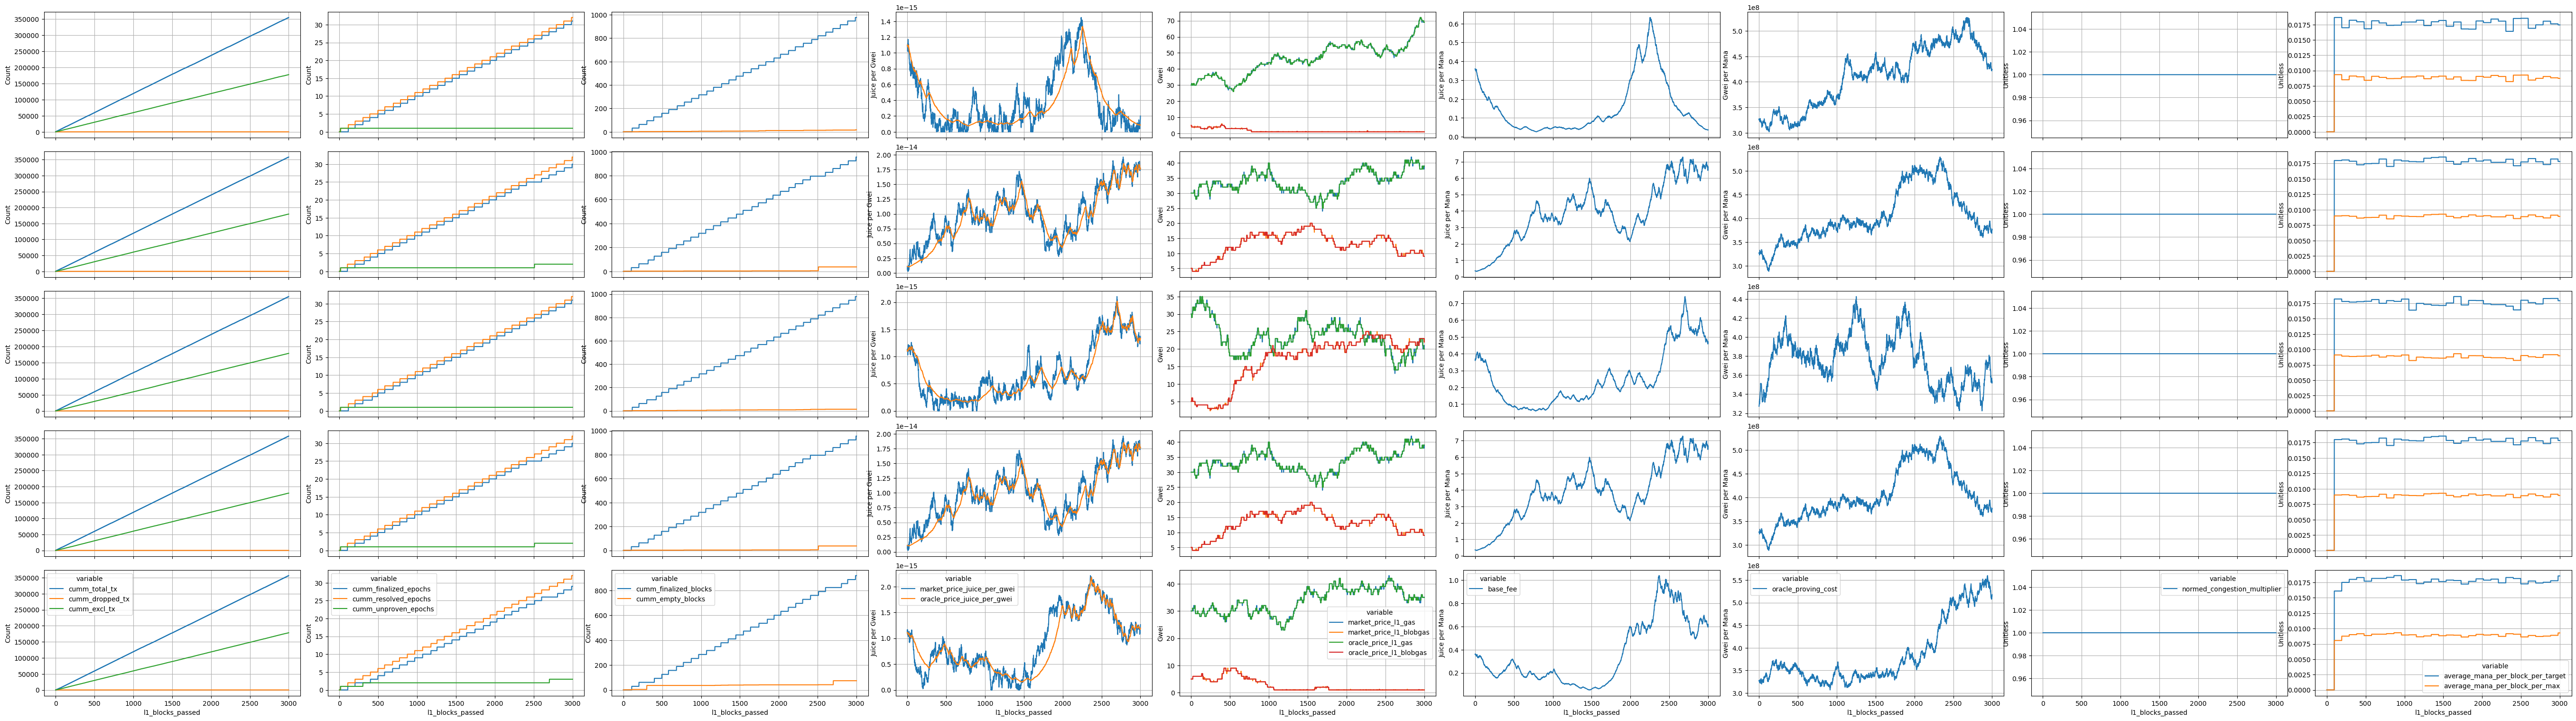

In [6]:
plot_inspect_vars(sim_df)

### Protocol Parameter Recommendations 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over table :dart: 
- [ ] :dart: Generate an analogue table below for the results :dart: 


| Control Parameter | Recommended Range | Unit |
| - | - | - |
| RELATIVE_TARGET_MANA_PER_BLOCK | tbd | Mana |
| MAXIMUM_MANA_PER_BLOCK | tbd | Mana |
| MINIMUM_MULTIPLIER_CONGESTION | tbd | Unitless |
| UPDATE_FRACTION_CONGESTION | tbd | 1 / Mana |
| OVERHEAD_MANA_PER_TX | tbd | Mana |
| PROVING_COST_MODIFIER_INITIAL_C | tbd | Mana |
| FEE_JUICE_PRICE_MODIFIER_INITIAL_C | tbd | Juice per Gwei |
| MAXIMUM_UPDATE_PERCENTAGE_C | tbd | Unitless |

### Decision Tree and Parameter Importance

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::
- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart:

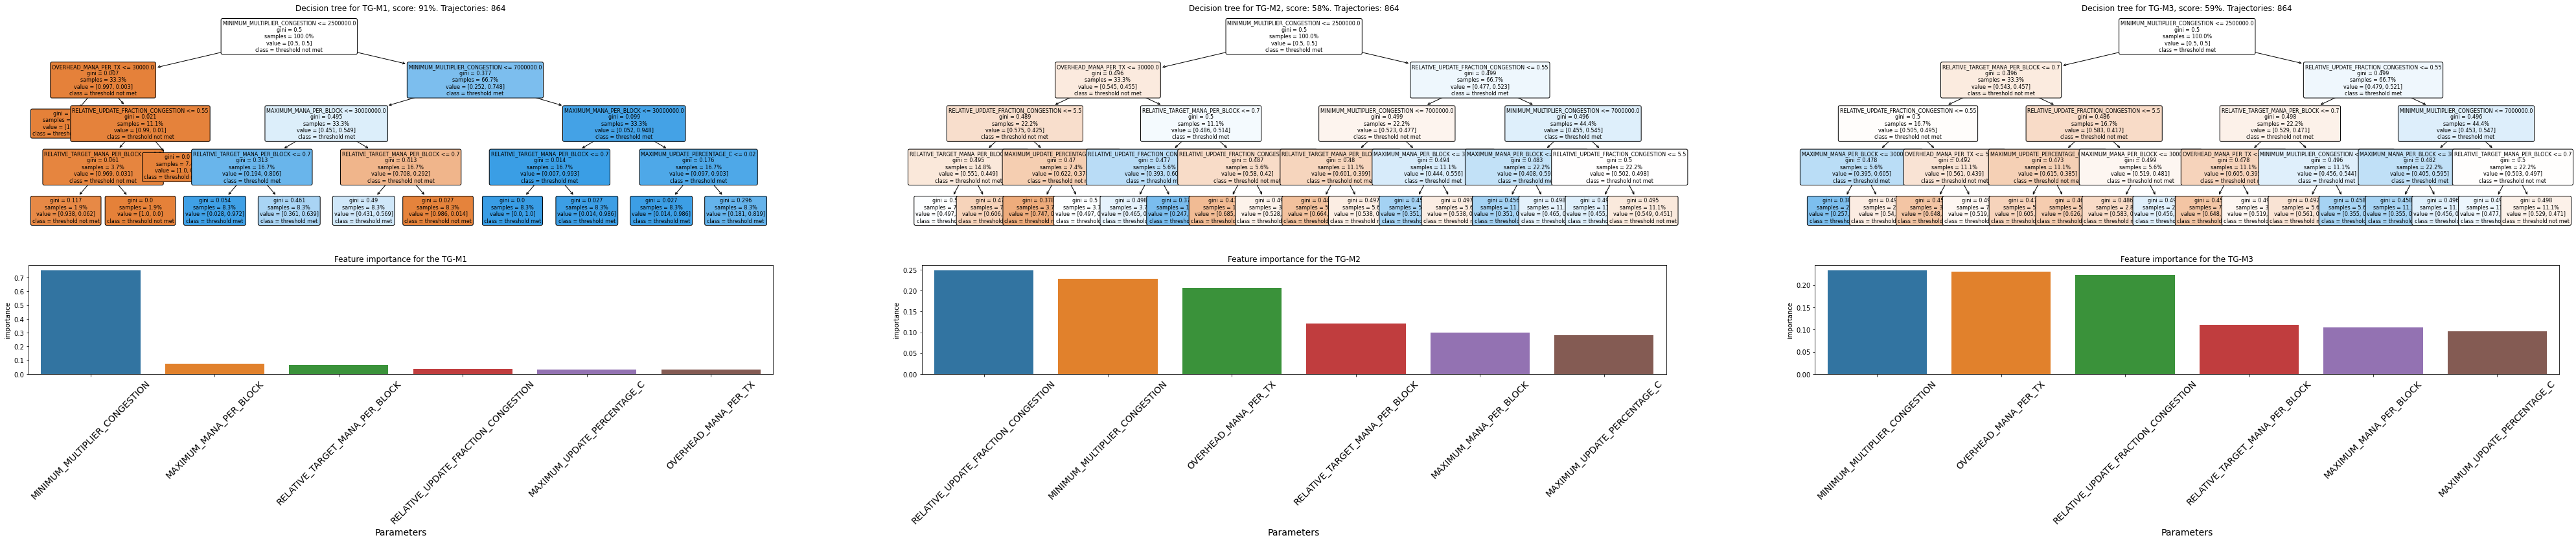

In [7]:
plot_agg_kpis(c_agg_df, exp_spec.params_swept_control, exp_spec.relevant_per_trajectory_group_metrics)

### Commentary on Results:

:dart: Write anything that comes up to mind based on the interpretation over all the results :dart: 

## Conclusion

- [ ] 🔫 Jakob owns after Danilo wrote commentary on results 🔫

## Appendix:
### Parameter Impact on Metrics: 

## 2. L2 Cost Censorship

In [8]:
# exp_spec = experiment_feemech_l2_cost_censorship

# # Override default configuration
# exp_spec.N_timesteps = 1_000
# exp_spec.N_samples = 1
# exp_spec.N_config_sample = 10

# CONTROL_PARAMS = list(exp_spec.params_swept_control.keys())

# sim_df, exec_time = execute_sim(exp_spec.prepare())
# agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)

path = 'gs://aztec-gddt-v2-sim/FM-SG2/2025-01-31T03:56:15Z/'

with fs.open(path + 'spec.json', 'r') as fid:
    exp_spec = ExperimentParamSpec.from_json(fid.read()) # type: ginore

sim_df = pd.read_pickle(path + 'timestep_tensor-0.pkl.gz')
agg_df = pd.read_pickle(path + 'trajectory_tensor.pkl.gz')
c_agg_df = compute_agg_df(exp_spec.relevant_per_trajectory_group_metrics, agg_df)

### Objective 
As the fee mechanism can return a different base fee at each timestep, users must specify a maximum fee per _mana_ value they are willing to pay, regardless of the movement of the base fee. This implies that a highly volatile base fee might render a "reasonably set" max fee per _mana_ value infeasible in practice--by the time a user's transaction is considered for inclusion in a block, the expected trajectory of the base fee may render the transaction unprofitable.

This scenario assesses the relative inclusion of transactions in a block according to sequencer profitability, based upon the _requirement_ that the maximum fee per _mana_ for any (included) transaction must **at least cover** the estimated base fee cost in a dynamically adjusting environment. By simulating shocks in this environment (which propagate to the fee mechanism computation), insights can be gained on the potential effects of transactions inclusion under different maximum fee per _mana_ and other protocol parameter assumptions.

### Experimental Setup

#### Testing Variables: 
:dart: we should check tthe below variables 

##### Environmental:

To simulate the effects of different user maximum fee per _mana_ values, a distribution of such values is specified and parameterized by its first two moments (mean, standard deviation).

To simulate the transaction block inclusion decision of a sequencer, a specified behavioral assumption is enforced: A transaction will be included if its maximum fee per _mana_ at least covers an expected base fee that is a modified (inflated) value of the latest base fee. This behavioral assumption was provided by the Aztec team to BlockScience for use in this scenario.

The secondary market exchange rate, L1 gas prices and proving costs are modeled as particular shocks, where each relevant time series may:

1. Strictly increase at a parameterized maximum change throughout the simulation, or 
2. Strictly decrease at a parameterized maximum change throughout the simulation, or
3. Be realized from random draws from a parameterized distribution, or
4. Stagnate without much change throughout the simulation.

##### Protocol

Different protocol parameters are investigated for their impact upon the base fee over the different environmental scenario subgroups described above. As the base fee is computed from various parametrizable components which do not have strong _ex ante_ values, this scenario tests a first group of parameter choices. 

This group consists of:

1. `OVERHEAD_MANA_PER_TX` - Each transaction incurs overhead mana costs of this size, irrespective of any conducted operations. 
2. `MAXIMUM_MANA_PER_BLOCK` - Each block is limited in *size* by this value, affecting profitability of sequencers, throughput of the network, and the computation of base fees directly. 
3. `TARGET_MANA_PER_BLOCK` - This value is needed to compute the congestion component of the base fee. 
4. `MAXIMUM_FEE_JUICE_PER_GWEI_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real secondary market price updates. In other words, the real secondary market price can fluctuate freely (such as in a flashcrash), while the oracle value used in practice by users is limited in change. Through this the base fee might lag behind in its conversion component when compared to a "real" secondary market price value used in computation. 
5. `MAXIMUM_PROVING_COST_GWEI_PER_MANA_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real proving cost updates. In other words, the proving cost experienced by provers might differ from the oracle value used in practice by users. Through this the base fee might lag behind in its proving cost component when compared to a "real" secondary market price value used in computation. 

#### Simulation input/output per Monte Carlo run:

##### Input:
For each parameter constellation of interest, we draw simulated time series for:

- Secondary market Fee Asset price,
- L1 gas price,
- Proving cost, and
- Transactions with different maximum fee per _mana_ amounts.

For random realizations, distributions for the above are parameterized by the first two moments (mean, variance).

##### Output:
- $\mathcal{M}$ Monte Carlo runs indexed by $m$.
- Time series of the base fee denominated in Fee Asset per _mana_
- Transactions included in each block
- Transactions dropped from each block


#### Sweep Parameters:
Refer to the [spreadsheet](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=955157985#gid=955157985&range=A1) for detailed parameter configurations related to staking and slashing mechanisms.

:dart: Fill in :dart:

##### Control:


In [9]:
exp_spec.print_control_params()

MAX_FEE_INFLATION_RELATIVE_STD: [0.05, 0.1, 0.2]
RELATIVE_TARGET_MANA_PER_BLOCK: [0.5, 0.9]
MAXIMUM_MANA_PER_BLOCK: [20000000, 40000000]
MINIMUM_MULTIPLIER_CONGESTION: [1000000, 4000000, 10000000]
RELATIVE_UPDATE_FRACTION_CONGESTION: [0.1, 1.0, 10.0]
OVERHEAD_MANA_PER_TX: [1000, 10000, 50000]
MAXIMUM_UPDATE_PERCENTAGE_C: [0.01, 0.03]


##### Environmental:

In [10]:
exp_spec.print_env_params()

MAX_FEE_INFLATION_RELATIVE_MEAN: [0.5, 1.0, 1.5]
MAX_FEE_INFLATION_RELATIVE_STD: [0.02, 0.1, 0.5]


#### Simulation Behavior:

**Profitability**
- A sequencer will not post a block to L1 if the revenue from the block is less than the cost of posting the block.
- A prover will not post a proof to L1 if the revenue from proving is less than the cost of posting the block.

**Inflation term**
- For each run, the mean $μ_B$ of the distribution of the maximum transaction fee per _mana_ for a block $B$ is set using the following rule:
$$μ_B := (1+\pi)F_{B−1},$$
where $\pi \geq 0$ is an inflation term that is swept over and $F_{B−1}$ is the base fee for the immediately previous block.

Intuitively, a transaction with a maximum fee per _mana_ value equal to the mean value $\mu_B$ will included in a block by a sequencer if $\mu_B \geq F_B$, where $F_B$ is the base fee of the current block, and dropped otherwise. 

#### Threshold Inequalities:

#### Metrics:
1. **Average percentage of dropped transactions**: $\bar{(\frac{T_I}{T_I+T_D})}$, where the average is taken over the $M$ MC runs of values $\frac{T_I^m}{T_I^m+{T_D^m}}$ and $T_I^m$ and $T_D^m$ are the total transactions included and dropped for MC run $m$, respectively.

     _Interpretation_: A high value indicates many transactions are dropped, while a low value indicates few values are dropped.

2. **Percentage of MC runs above dropped threshold** ([PERCENTAGE_CENSORSHIP_LIMIT_M](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=1840722092#gid=1840722092&range=A39)): The proportion of all MC runs for which the average percentage of dropped transactions was less than a THRESHOLD AMOUNT.

     _Interpretation_: The percentage of Monte Carlo runs where the fraction of L2 transactions censored due to cost remains below a threshold.

#### Computational Complexity:

In [12]:
print(complexity_desc(exp_spec))


    #### Computational Complexity:
    1. Total number of parameter combinations: 5,832
    2. Total number of Monte Carlo runs per parameter combination: 3
    3. Total number of trajectories: 17,496
    4. Total number of timesteps per trajectory: 3,000
    5. Total number of state measurements: 52,488,000
    


### Simulation Results 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart: 

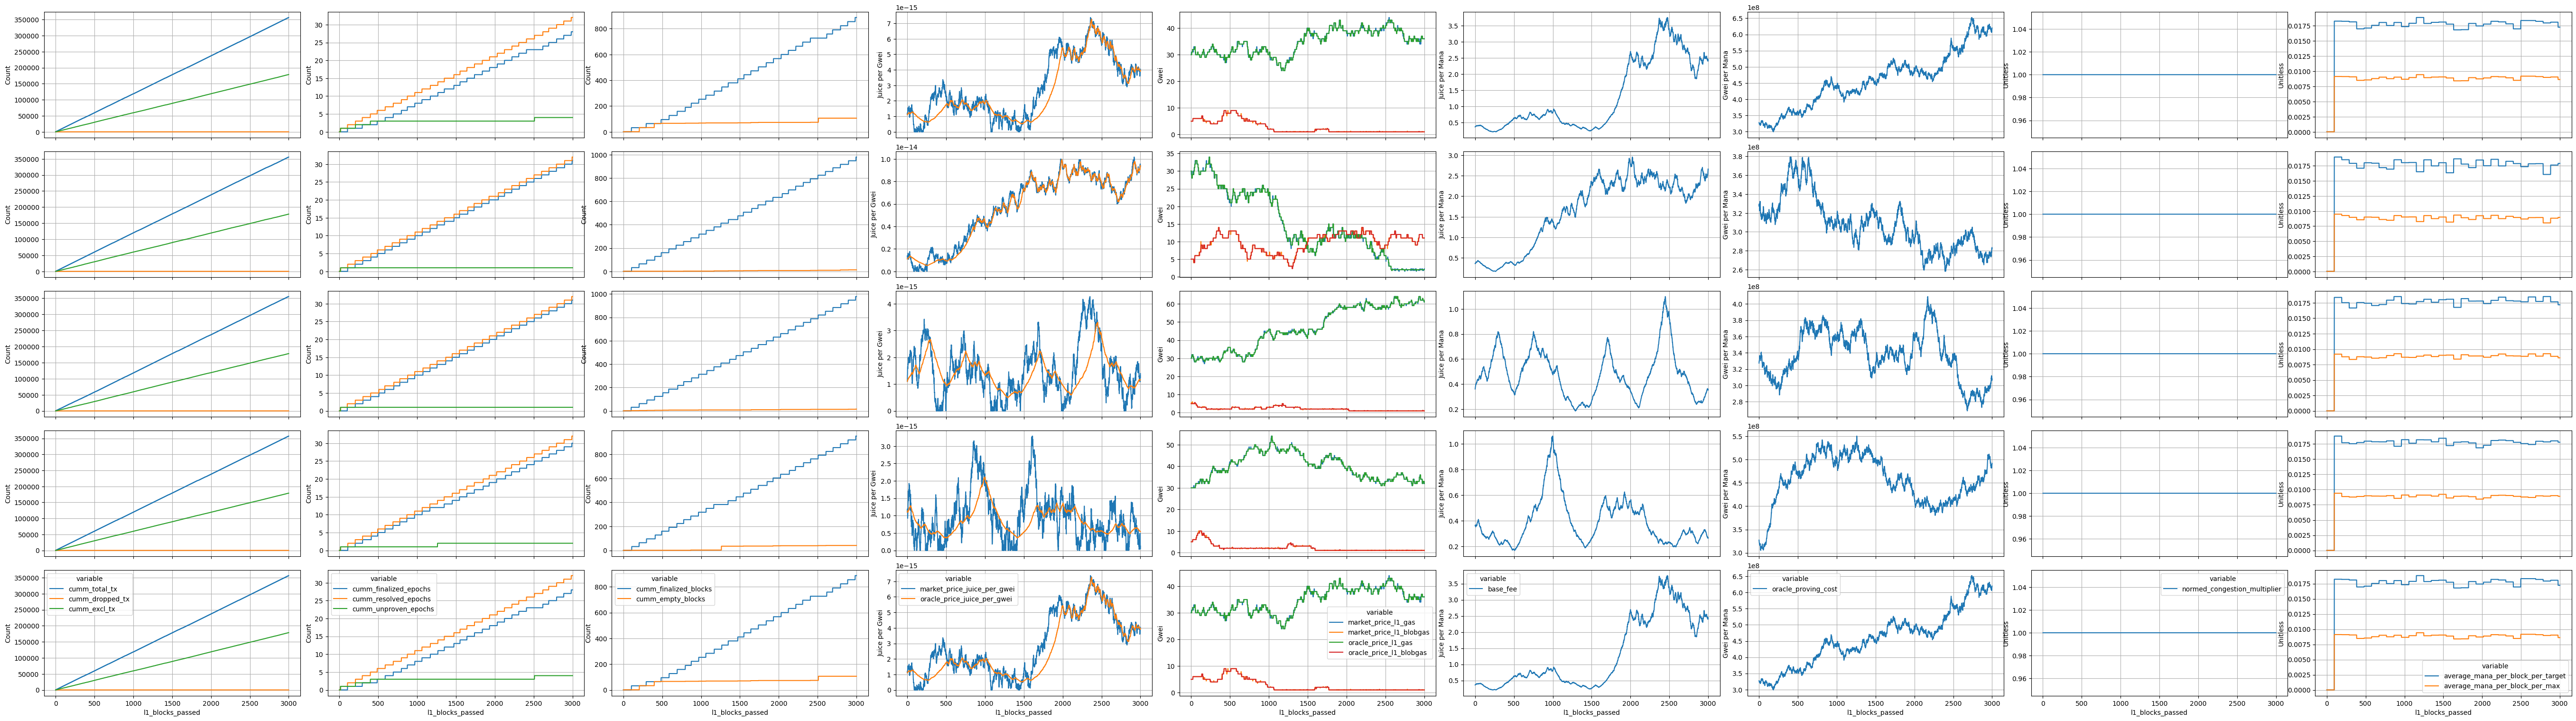

In [13]:
plot_inspect_vars(sim_df)

### Protocol Parameter Recommendations 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over table :dart: 
- [ ] :dart: Generate an analogue table below for the results :dart: 

### Decision Tree and Parameter Importance

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::
- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart:

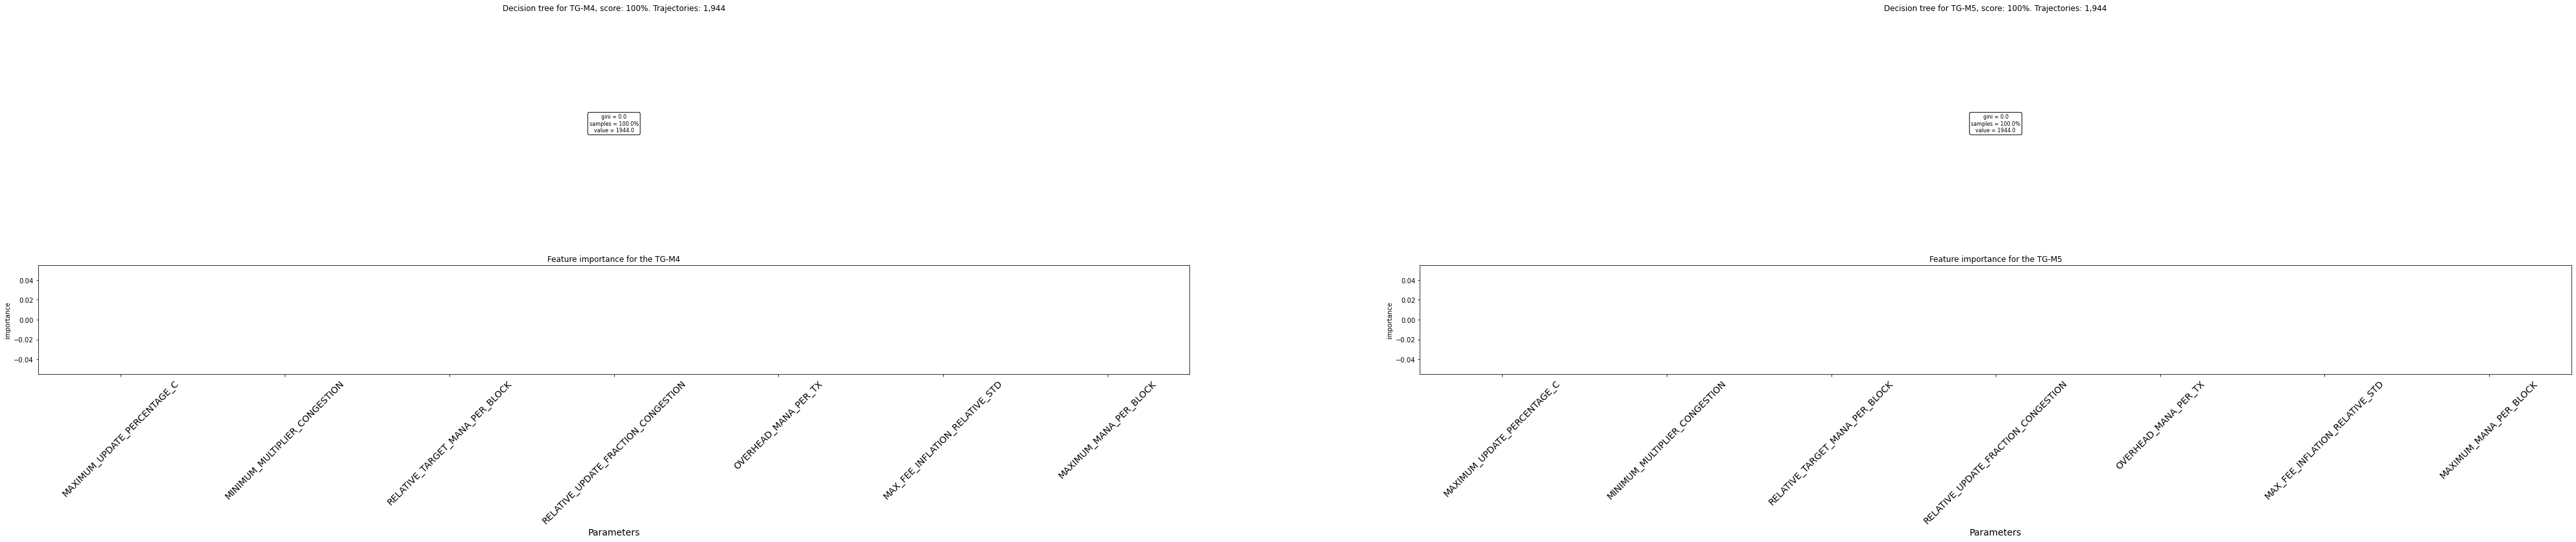

In [14]:
plot_agg_kpis(c_agg_df, exp_spec.params_swept_control, exp_spec.relevant_per_trajectory_group_metrics)

### Commentary on Results:

:dart: Write anything that comes up to mind based on the interpretation over all the results :dart: 

## Conclusion

- [ ] 🔫 Jakob owns after Danilo wrote commentary on results 🔫

## Appendix:
### Parameter Impact on Metrics: 

## 3. Congestion Shock Analysis

In [ ]:
# exp_spec = experiment_feemech_shock_analysis

# # Override default configuration
# exp_spec.N_timesteps = 1_000
# exp_spec.N_samples = 1
# exp_spec.N_config_sample = 10

# CONTROL_PARAMS = list(exp_spec.params_swept_control.keys())

# sim_df, exec_time = execute_sim(exp_spec.prepare())
# agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)

path = 'gs://aztec-gddt-v2-sim/FM-SG3/2025-01-31T03:24:30Z/'

with fs.open(path + 'spec.json', 'r') as fid:
    exp_spec = ExperimentParamSpec.from_json(fid.read()) # type: ginore

sim_df = pd.read_pickle(path + 'timestep_tensor-0.pkl.gz')
agg_df = pd.read_pickle(path + 'trajectory_tensor.pkl.gz')
c_agg_df = compute_agg_df(exp_spec.relevant_per_trajectory_group_metrics, agg_df)

### Objective 
The fee mechanism is affected by both:

- L1 congestion (through *limited L1 block space*, resulting in high gas and blob gas prices, as well as potential unavailability of settlement), and
- L2 congestion (through the *congestion component* of the fee mechanism).

These congestions effects are important because the propagation of congestion effects to the base fee can have either _distortionary_ effects, such as amplifying base fee volatility or introducing an unwanted trend, or _regularity_ effects, such as reducing transactions demand during high congestion periods (thereby reducing congestion toward a desired 'baseline').

This scenario assesses:
1. The stability of the base fee, and
2. The effects of its movement upon the degree to which transactions are included or excluded from a block,

when congestion shocks are introduced.

### Experimental Setup

#### Testing Variables: 
:dart: we should check the below variables 

##### Environmental:

The simulation of L2 congestion effects is accomplished by introducing a time series for _transactions volume_ that exhibits low or high network congestion. This is modeled by simulating _excursions_ from periods of low volatility to periods of high volatility for a fixed duration of time.

The L1 gas price time series, representing the effect of limited L1 block space, is modeled as resulting from particular shocks and may:

1. Strictly increase at a parameterized maximum change throughout the simulation, or 
2. Strictly decrease at a parameterized maximum change throughout the simulation, or
3. Be realized from random draws from a parameterized distribution, or
4. Stagnate without much change throughout the simulation.


##### Protocol: 
Different protocol parameters are investigated for their impact upon the base fee over the different environmental scenario subgroups described above. As the base fee is computed from various parametrizable components which do not have strong _ex ante_ values, this scenario tests a first group of parameter choices. 

This group consists of:

1. `OVERHEAD_MANA_PER_TX` - Each transaction incurs overhead mana costs of this size, irrespective of any conducted operations. 
2. `MAXIMUM_MANA_PER_BLOCK` - Each block is limited in *size* by this value, affecting profitability of sequencers, throughput of the network, and the computation of base fees directly. 
3. `TARGET_MANA_PER_BLOCK` - This value is needed to compute the congestion component of the base fee. 
4. `MAXIMUM_FEE_JUICE_PER_GWEI_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real secondary market price updates. In other words, the real secondary market price can fluctuate freely (such as in a flashcrash), while the oracle value used in practice by users is limited in change. Through this the base fee might lag behind in its conversion component when compared to a "real" secondary market price value used in computation. 
5. `MAXIMUM_PROVING_COST_GWEI_PER_MANA_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real proving cost updates. In other words, the proving cost experienced by provers might differ from the oracle value used in practice by users. Through this the base fee might lag behind in its proving cost component when compared to a "real" secondary market price value used in computation. 

#### Simulation input/output per Monte Carlo run:

##### Input:

For each parameter constellation of interest, we draw simulated time series for:

1. L2 transactions volume representing "low" and "high" network congestion, where "low" is parameterized by a distribution with mean $\mu_L$ and "high" is parameterized by a distribution with mean $\mu_L + \Delta_\mu$, with $\Delta_\mu > 0$. The time series exhibits a "shock" from low to high L2 congestion for a duration $t_\mu > 0$, and subsequently returns to low congestion.
2. L1 gas prices representing "low" and "high" costs, where "low" is parameterized by a distribution with a mean $\gamma_L$ and "high" is parameterized by a distribution with a mean $\gamma_L + \Delta_\gamma$, with $\Delta_\gamma > 0$. The time series exhibits a "shock" from low to high L1 costs for a duration $t_\gamma > 0$, and subsequently returns to low costs.

Realizations of $(\Delta_\mu, \Delta_\gamma)$ and $(t_\mu, t_\gamma)$ are drawn from respective distributions with given (mean, variance) moments. Each pair may exhibit correlated or uncorrelated movements depending upon their respective covariance matrices

##### Output:  

- $\mathcal{M}$ Monte Carlo runs indexed by $m$.
- Time series of the base fee denominated in Fee Asset per _mana_
- Transactions included in each block
- Transactions dropped from each block

#### Sweep Parameters:
Refer to the [spreadsheet](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=955157985#gid=955157985&range=A1) for detailed parameter configurations related to staking and slashing mechanisms.

:dart: Fill in :dart:

##### Control:

In [ ]:
exp_spec.print_control_params()

##### Environmental:

In [ ]:
exp_spec.print_env_params()

#### Simulation Behavior:
1. A sequencer will not post a block to L1 if the revenue from the block is less than the cost of posting the block.
2. A prover will not post a proof to L1 if the revenue from proving is less than the cost of posting the block.

#### Threshold Inequalities:

#### Metrics:
1. **Average percentage of excluded transactions**: $\bar{(\frac{T_I}{T_I+T_E})}$, where the average is taken over the M MC runs of values $\frac{T_I^m}{T_I^m+{T_E^m}}$ and ${T_I^m}$ and${T_E^m}$ are the total transactions included and excluded for MC run $m$, respectively.

     _Interpretation_: A high value indicates that the network congestion and/or L1 gas cost shocks impact the base fee to the extent that many otherwise available transactions are not included in a block.


2. **Percentage of return to base fee** ([PERCENTAGE_RETURN_TO_BASE_M](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=1840722092#gid=1840722092&range=A41)): The proportion of MC runs where the base fee returns to within a percentage of the base fee after the shock has concluded.

     _Interpretation_: A high percentage indicates that the fee mechanism is _resilient_ to congestion and/or L1 gas cost shocks, returning to a 'baseline' base fee value after the shock has passed.



#### Computational Complexity:

In [ ]:
print(complexity_desc(exp_spec))

### Simulation Results 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart: 

In [ ]:
plot_inspect_vars(sim_df)

### Protocol Parameter Recommendations 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over table :dart: 
- [ ] :dart: Generate an analogue table below for the results :dart: 

### Decision Tree and Parameter Importance

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::
- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart:

In [ ]:
plot_agg_kpis(c_agg_df, exp_spec.params_swept_control, exp_spec.relevant_per_trajectory_group_metrics)

### Commentary on Results:

:dart: Write anything that comes up to mind based on the interpretation over all the results :dart: 

## Conclusion

- [ ] 🔫 Jakob owns after Danilo wrote commentary on results 🔫

## Appendix:
### Parameter Impact on Metrics: 

## 4. Oracle Sensitivity

In [ ]:
exp_spec = experiment_feemech_oracle_sensitivity

# Override default configuration
exp_spec.N_timesteps = 1_000
exp_spec.N_samples = 1
exp_spec.N_config_sample = 10

CONTROL_PARAMS = list(exp_spec.params_swept_control.keys())

sim_df, exec_time = execute_sim(exp_spec.prepare())
agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)

### Objective 
The fee mechanism includes components relying on oracle-supplied values rather than having direct access to actual values. Considering that oracles might not be updated (and/or *updateable*) in real-time, and that their maximum change per update might be bounded, there can exist delays (or _lags_) between oracle and actual values. As oracle values are used in the fee mechanism, it is important to understand the impact of these lags on base fee dynamics. For example, if the oracle and actual values _diverge_ because of lags, users/sequencers/provers may not have access to a realistic cost/profit calculation when using the base fee. 

This scenario specifically tests the sensitivity of the fee mechanism to errors propagated through oracle channels, which are external sources of truth not directly controlled by Aztec.

### Experimental Setup

#### Testing Variables: 
:dart: we should check the below variables 

##### Environmental:

The simulation of oracle-supplied time series is accomplished by introducing several subgroup scenarios, depending upon the type of oracle data being examined:
1. Proving cost oracle data: the oracle time series representing the proving cost, which depends upon the maximum change in the oracle's proving cost (`PROVING_COST_MODIFICATION_E`),
2. Fee juice per _gwei_ oracle data: the oracle time series representing the secondary market price of juice, which depends upon the maximum change in the oracle's price (`FEE_JUICE_PRICE_MODIFICATION_E`).

Each of these time series may have their maximum change take one of the following forms: 

1. Strictly increase at a parameterized maximum change throughout the simulation, or 
2. Strictly decrease at a parameterized maximum change throughout the simulation, or
3. Stagnate without much change throughout the simulation.

In addition, each time series is subject to a potential _delay_ in its reporting of actual values. This delay is modeled as potentially occurring on a block-by-block basis, and has a protocol-specified minimum value (current 5 blocks).


##### Protocol:
Different protocol parameters are investigated for their impact upon the base fee over the different environmental scenario subgroups described above. As the base fee is computed from various parametrizable components which do not have strong _ex ante_ values, this scenario tests a first group of parameter choices. 

This group consists of:

1. `OVERHEAD_MANA_PER_TX` - Each transaction incurs overhead mana costs of this size, irrespective of any conducted operations. 
2. `MAXIMUM_MANA_PER_BLOCK` - Each block is limited in *size* by this value, affecting profitability of sequencers, throughput of the network, and the computation of base fees directly. 
3. `TARGET_MANA_PER_BLOCK` - This value is needed to compute the congestion component of the base fee. 
4. `MAXIMUM_FEE_JUICE_PER_GWEI_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real secondary market price updates. In other words, the real secondary market price can fluctuate freely (such as in a flashcrash), while the oracle value used in practice by users is limited in change. Through this the base fee might lag behind in its conversion component when compared to a "real" secondary market price value used in computation. 
5. `MAXIMUM_PROVING_COST_GWEI_PER_MANA_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real proving cost updates. In other words, the proving cost experienced by provers might differ from the oracle value used in practice by users. Through this the base fee might lag behind in its proving cost component when compared to a "real" secondary market price value used in computation.

#### Simulation input/output per Monte Carlo run:

##### Input:
For each parameter constellation of interest, we draw simulated time series for one of the following scenario subgroups:

1. The proving cost modification (`PROVING_COST_MODIFICATION_E`),
2. The fee juice price modification (`FEE_JUICE_PRICE_MODIFICATION_E`), and
3. The update frequency of each oracle (`ORACLE_UPDATE_FREQUENCY_E`), which is the probability in any L2 block that the oracle could be updated.

Whether or not the oracle is actually updated depends upon its last update time--an oracle value can only be updated if at least `MIN_ORACLE_UPDATE_LAG_C` (set to 5 in the simulations) has passed.

##### Output:  
- $\mathcal{M}$ Monte Carlo runs indexed by $m$.
- Time series of the base fee denominated in Fee Asset per _mana_


#### Sweep Parameters:
Refer to the [spreadsheet](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=955157985#gid=955157985&range=A1) for detailed parameter configurations related to staking and slashing mechanisms.

:dart: Fill in :dart:

##### Control:

In [ ]:
exp_spec.print_control_params()

exp_spec.print_env_params()

In [ ]:
exp_spec.print_env_params()

#### Simulation Behavior:

- A sequencer will prefer an oracle environment that provides a higher revenue than other environments.


#### Threshold Inequalities:

#### Metrics:
1. **Average Elasticity of the Base Fee**: Defined as the percentage change in the base fee divided by the percentage change in the oracle parameter, averaged over Monte Carlo runs.

     _Interpretation_: A value of the metric greater than 1 indicates that the base fee is sensitive to changes in the oracle parameter, making it more susceptible to spurious errors (as modeled by the distribution that the errors are drawn from). A value less than 1 implies that the base fee is less sensitive to such changes, improving its predictability and 'inoculation' against spurious errors.

2. **Sequencer Losses**: Calculated as the average difference between 1) the sequencer's potential revenue at the minimum oracle lag and 2) the actual revenue with an update frequency lag in place. The sequencer's potential revenue is calculated when the update frequency of each oracle (`ORACLE_UPDATE_FREQUENCY_E`) is equal to 1, i.e. when the oracle is always updated at least `MIN_ORACLE_UPDATE_LAG_C` blocks (the minimum update frequency the protocol permits). This is a 'baseline' revenue figure and is interpreted as the sequencer's experience if the oracle were not subject to more than the stipulated minimum lag. 

     _Interpretation_: A large positive value indicates that the sequencer has been negatively affected by oracle lag over and above the protocol-imposed minimum lag. Conversely, a negative value means that the sequencer actually benefited from the lag (this may be impossible given the way the base fee is computed).

#### Computational Complexity:

In [ ]:
print(complexity_desc(exp_spec))

### Simulation Results 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart: 

In [ ]:
plot_inspect_vars(sim_df)

### Protocol Parameter Recommendations 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over table :dart: 
- [ ] :dart: Generate an analogue table below for the results :dart: 

### Decision Tree and Parameter Importance

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::
- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart:

In [ ]:
plot_agg_kpis(c_agg_df, exp_spec.params_swept_control, exp_spec.relevant_per_trajectory_group_metrics)

### Commentary on Results:

:dart: Write anything that comes up to mind based on the interpretation over all the results :dart: 

## Conclusion

- [ ] 🔫 Jakob owns after Danilo wrote commentary on results 🔫

## Appendix:
### Parameter Impact on Metrics: 